# Datathon - Price Anomaly Detection
## Team H

### Index

1. Import Data  
2. Clean Data  
3. Feature Extraction
4. Anomalies - Fixed rules  
5. Data Exploration
6. Model
7. Submission
    * Gaussian Enevlope - by City
    * Gaussian Envelope - by Star Rating
8. Alternative approaches
    * Local Outlier Factor
    * Isolation Forest
    * Clustering

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
# import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

%matplotlib inline

In [113]:
def df_summary(df):
    # intialize data frame
    col_missing = pd.DataFrame()

    # initialize columns
    unique_list = pd.Series()
    missing_list = pd.Series()
    zeros_list = pd.Series()
    #negative_list = pd.Series()
    
    # data frame columns
    colnames = df.columns

    # create columns with unique, null and zero countsa
    for col in colnames:
        unique_list = unique_list.append(pd.Series(len(df[col].unique())))
        missing_list = missing_list.append(pd.Series(len(df[df[col].isnull()])))
        zeros_list = zeros_list.append(pd.Series(len(df[df[col] == 0])))
        #negative_list = negative_list.append(pd.Series(len(df[df[col] < 0])))

    # put in data frame
    col_missing = pd.DataFrame( {'unique': unique_list,
                                 'missing': missing_list,
                                 'zeroes': zeros_list
                                 #'negative': negative_list
                                })
    
    # row names -> features
    col_missing.index = colnames
    
    # return data frame
    return col_missing

# 1. Import data

In [114]:
# import data frame
#df = pd.read_csv("./data/DATATHON_STU.csv")
df = pd.read_csv("./data/DATATHON_STU_NEW.csv")
df = df.drop(df.columns[0], axis=1)

In [115]:
# import table with features' description
df_info = pd.read_excel("./data/IEDatathon2018_DataTable.xlsx", sheet_name = "data")
df_info = df_info.drop(df_info.columns[0], axis=1)

### Features Description Table

In [116]:
df_info

,Field,Description
0,hotel_hkey,hotel identifier
1,contract_id_hkey,contract identifier
2,id_hkey,booking id identifier
3,city_code,the code for the destination
4,category_room,the room class
5,contract_type,the style of contract for the hotel (non-refun...
6,room_type,"the style of room (single, double, twin…)"
7,meal_basis,"the type of meal arrangement (room only, bed &..."
8,creation_date,the date of the booking (date format is YYYY-M...
9,arrival_date,the start of the hotel stay (date format is YY...


### Training Data

In [117]:
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,departure_date,total_cost,star_rating,row_id
0,-8311839113995541010,3308171939935307043,-6758561262332566539,1,BL-6,OPQ,APT,RO,2018-05-22,2018-06-30,2018-07-05,14192.496000,APARTMENT,0
1,-7782336419181110673,-3269338087318960614,-9183082468560560492,8,ST,NOR,DBT,BB,2018-05-22,2018-07-20,2018-07-24,3558.469200,1,1
2,-8185637807857201025,-7171383991101553094,-573449065418159891,6,XX-KG-SU,NOR,DBL,RO,2018-05-22,2018-05-24,2018-05-29,17319.714354,5,2
3,4398388086357359587,3421074771505167982,215759992217563846,2,ST,NONE,TWN,BB,2018-05-22,2018-06-08,2018-06-11,3321.785004,3,3
4,-7098207282290159573,7965439627984399332,1006074091123194605,7,ST,NOR,DBT,RO,2018-05-22,2018-06-11,2018-06-14,2586.300000,3,4


In [118]:
# shape
print(df.shape)

(899477, 14)


In [119]:
# summary of features
df.describe()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,total_cost,row_id
count,8.994770e+05,8.994770e+05,8.994770e+05,899477.000000,8.906640e+05,899477.000000
mean,1.083493e+16,4.711366e+17,-6.230768e+15,4.121188,5.943849e+03,449738.000000
std,5.235064e+18,5.051348e+18,5.324098e+18,2.662908,4.351145e+04,259656.788376
min,-9.221152e+18,-9.223151e+18,-9.223361e+18,0.000000,-8.388000e+03,0.000000
25%,-4.536184e+18,-3.916437e+18,-4.623797e+18,2.000000,1.485651e+03,224869.000000
50%,2.100855e+17,1.532957e+18,-3.724238e+15,4.000000,3.462566e+03,449738.000000
75%,4.412958e+18,3.746794e+18,4.602796e+18,7.000000,7.339500e+03,674607.000000
max,9.220866e+18,9.222155e+18,9.223327e+18,8.000000,3.553954e+07,899476.000000


From the summary function - `df_summary` - previously defined, we print the number of *missing*, *unique* and *zero* values.  
* The only *missing* values belong to `total_cost`, which we will further analyze.  
* There are 9 cities visible from `city_code` unique values and surprisingly `category_room` has 1320 different levels. It's possible to see how many days are in the dataset from the three dates columns.  
* Zero values are not a worning for any of the features

In [120]:
df_summary(df)

,missing,unique,zeroes
hotel_hkey,0,6366,0
contract_id_hkey,0,16789,0
id_hkey,0,873787,0
city_code,0,9,75922
category_room,0,1320,0
contract_type,0,7,0
room_type,0,24,0
meal_basis,0,17,0
creation_date,0,176,0
arrival_date,0,701,0


In [121]:
# convert date columns to datetime type
df['creation_date'] = pd.to_datetime(df.creation_date)
df['arrival_date'] = pd.to_datetime(df.arrival_date)
df['departure_date'] = pd.to_datetime(df.departure_date)

In [122]:
# print varaibles information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899477 entries, 0 to 899476
Data columns (total 14 columns):
hotel_hkey          899477 non-null int64
contract_id_hkey    899477 non-null int64
id_hkey             899477 non-null int64
city_code           899477 non-null int64
category_room       899477 non-null object
contract_type       899477 non-null object
room_type           899477 non-null object
meal_basis          899477 non-null object
creation_date       899477 non-null datetime64[ns]
arrival_date        899477 non-null datetime64[ns]
departure_date      899477 non-null datetime64[ns]
total_cost          890664 non-null float64
star_rating         899477 non-null object
row_id              899477 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(5), object(5)
memory usage: 96.1+ MB
None


# 2. Clean Data

### NAs

The only `NA` values are present in the `total_cost` variable. Analyzing the data, we found out that the majority of them are related to duplicated rows that appear when a customer booked two or more identical rooms in the same session.

In [123]:
# drop rows that still have NAs (1)
df.isna().sum()

hotel_hkey             0
contract_id_hkey       0
id_hkey                0
city_code              0
category_room          0
contract_type          0
room_type              0
meal_basis             0
creation_date          0
arrival_date           0
departure_date         0
total_cost          8813
star_rating            0
row_id                 0
dtype: int64

### Duplicated Values

From the data frame with duplicated values - `df_dup` - we can see that duplicated observations are missing the `total_cost`. Since there is not a variable indicating the number of rooms per reservation, we assume that when the customer booked two (or in some cases three or more) identical rooms - i.e. families or businesses for their employees - the system collects both reservation but the price is indicated only in the first one since it would be the same in the other one(s). Hence, we can input the missing data copying the price between a set of duplicated reservations.  
Below we declare a function - `duplicated_values` -  that replicates the price over a set of duplicated values in the `df_dup` data frame and copies the value by their index in the original data frame `df`.

In [124]:
# columns that we want to consider to search for duplicates - in this case we want all the columns to be the same
duplicated_cols = ['id_hkey', 'hotel_hkey', 'contract_id_hkey', 'id_hkey', 'city_code', 
                   'category_room', 'contract_type', 'room_type', 'meal_basis', 
                   'creation_date', 'arrival_date', 'departure_date'
                  ]

In [125]:
# data frame with duplicated values, we sort it by id_hkey and total_cost so that we have as first row 
# for each transaction (key) the observation with the total_cost followed by the observation(s) without it
df_dup = df[df.duplicated(subset= duplicated_cols, keep = False)].sort_values(by=['id_hkey', 'total_cost'])

In [126]:
df_dup.head(4)

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,departure_date,total_cost,star_rating,row_id
625932,4803788277351251882,3421074771505167982,-9223092833591955833,6,ST,NONE,ROO,RO,2018-05-01,2018-05-26,2018-05-27,2694.758238,4,625932
881654,4803788277351251882,3421074771505167982,-9223092833591955833,6,ST,NONE,ROO,RO,2018-05-01,2018-05-26,2018-05-27,NaN,4,881654
13369,-6708754669226474969,3421074771505167982,-9221346839323373152,3,XX-NM,NONE,TWN,BB,2018-04-04,2018-08-15,2018-08-16,811.469100,3,13369
140320,-6708754669226474969,3421074771505167982,-9221346839323373152,3,XX-NM,NONE,TWN,BB,2018-04-04,2018-08-15,2018-08-16,NaN,3,140320


In [127]:
def fix_duplicated_values(df):
    # REPLICATE the price in the set of duplicated values
    # iterate for every row in the df_dup data frame
    for i in range(1, df_dup.shape[0], 1):
        
        # identify duplicated groups by the key of the previous observation
        if df_dup.iloc[i, 2] == df_dup.iloc[i-1, 2]:
            
            # replace the NA value
            df_dup.iloc[i, 11] = df_dup.iloc[i-1, 11]
            
    # INSERT the values in the original data frame, using the columns' index
    for i in df_dup.index:
        df.loc[i, "total_cost"] = df_dup.loc[i, "total_cost"]

In [128]:
fix_duplicated_values(df)

### Remaining NAs

As mentioned earlier, not all (but only the majority) NAs were explained by the *duplicated* fact. The rest of the values are not explained, hence we will take care of them later.

In [129]:
df['total_cost'].isna().sum()

125

# 3. Feature Extraction

We extract relevant feartures from the columns of the data set:
* from the `dates` we calculate the duration in days of the trip - `trip_duration` - and the number of days in advance that the trip was booked - `booking_lag`.  
* the cost per night of the hotel booked - `price_per_night` - derived from the `total_cost` and the `trip_duration`
* the weekday (Monday=0, Sunday=6) of the booking - `creation_date_wday`  
* a boolean value indicating whether the trip included a weekend or not

### New Features

#### Trip duration & Booking lag

In [130]:
# trip duration
df['trip_duration'] = ((df.departure_date - df.arrival_date) / np.timedelta64(1, 'D')).astype(int)
# booking lag
df['booking_lag'] = ((df.arrival_date - df.creation_date) / np.timedelta64(1, 'D')).astype(int)

#### Price per night

In [131]:
# price per night
df['price_per_night'] = df['total_cost'] / df['trip_duration']

#### Booking weekday

In [132]:
# weekday of booking date
df['creation_date_wday'] = df['creation_date'].dt.weekday

In [133]:
df['creation_date_wday_name'] = df['creation_date'].dt.weekday_name

#### Weekend included

In [134]:
# initilize variable
df['weekend_trip'] = 0
# if the arrival date plus the duration of the trip is greater or equal to 5 it includes a weekend
df.loc[(df['arrival_date'].dt.weekday + df['trip_duration']) >= 5, 'weekend_trip'] = 1

In [135]:
print("Number of trips including weekends: %s" % df[df.weekend_trip == 1]['hotel_hkey'].count())

Number of trips including weekends: 630429


#### Time Epoch

In [136]:
#Date to Numeric
df['time_epoch'] = (df['creation_date'].astype(np.int64)/100000000000).astype(np.int64)

In [137]:
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,...,total_cost,star_rating,row_id,trip_duration,booking_lag,price_per_night,creation_date_wday,creation_date_wday_name,weekend_trip,time_epoch
0,-8311839113995541010,3308171939935307043,-6758561262332566539,1,BL-6,OPQ,APT,RO,2018-05-22,2018-06-30,...,14192.496000,APARTMENT,0,5,39,2838.499200,1,Tuesday,1,15269472
1,-7782336419181110673,-3269338087318960614,-9183082468560560492,8,ST,NOR,DBT,BB,2018-05-22,2018-07-20,...,3558.469200,1,1,4,59,889.617300,1,Tuesday,1,15269472
2,-8185637807857201025,-7171383991101553094,-573449065418159891,6,XX-KG-SU,NOR,DBL,RO,2018-05-22,2018-05-24,...,17319.714354,5,2,5,2,3463.942871,1,Tuesday,1,15269472
3,4398388086357359587,3421074771505167982,215759992217563846,2,ST,NONE,TWN,BB,2018-05-22,2018-06-08,...,3321.785004,3,3,3,17,1107.261668,1,Tuesday,1,15269472
4,-7098207282290159573,7965439627984399332,1006074091123194605,7,ST,NOR,DBT,RO,2018-05-22,2018-06-11,...,2586.300000,3,4,3,20,862.100000,1,Tuesday,0,15269472


# 4. Anomalies - Fixed Rules

We use a set of fixed rules to identify **global** anomalies:
* `total_cost`: negative values and nulls that do not fall into the *duplicated* scenario . 
* `price_per_night`: values that are extremely high or extremely low and do not belong to the distribution. We set a threshold of respectively 60,000 and 12.  
* `booking_lag`: some values are negative (even if impossible), we keep them because they do not affect the model and we can't infer that are related to price anomalies.

### Total Cost

In [138]:
# initialize anomaly column - by deafault no anomalies (value = 0)
df['anomaly'] = 0

In [139]:
# The function classifies as anomalies total_cost observations that are negative or NA
def total_cost_anomaly(df):
    # NEGATIVE values
    # print number of values
    print("# negative total_cost: %s" % df.loc[df.total_cost <= 0, "anomaly"].count())
    # replace values with 1
    df.loc[df.total_cost <= 0, "anomaly"] = 1
    
    # NA values
    # print number of values
    print("# null total_cost: %s" % df.loc[df.total_cost.isnull(), "anomaly"].count())
    # replace values with 1
    df.loc[df.total_cost.isnull(), "anomaly"] = 1

In [140]:
total_cost_anomaly(df)

# negative total_cost: 7
# null total_cost: 125


### Price per night

In [141]:
# The function classifies as anomalies price_per_night observations that are over or below a defined threshold 
# the threshold is set by default to 60,000 (over) and 12 (below)
def price_per_night_anomaly(df, over = 60000, below = 12):
    # OVER THRESHOLD
    # print number of values
    print("# over 60,000: %s" % df.loc[df.price_per_night >= over, "anomaly"].count())
    # replace values with 1
    df.loc[df.price_per_night >= over, "anomaly"] = 1
    
    # BELOW THRESHOLD
    # print number of values
    print("# below 12: %s" % df.loc[df.price_per_night <= below, "anomaly"].count())
    # replace values with 1
    df.loc[df.price_per_night <= below, "anomaly"] = 1

In [142]:
price_per_night_anomaly(df)

# over 60,000: 17
# below 12: 12


### Booking Lag

`booking_lag` has negative values.

In [143]:
# count of negative booking lags
df[df.booking_lag < 0]['hotel_hkey'].count()

535

In [144]:
# keep values that have not negative booking lag
#df = df[df.booking_lag >= 0]

In [145]:
df.shape

(899477, 22)

# 5. Data Exploration

### Time period

In [146]:
# creation date
print("creation date")
print(df.creation_date.min())
print(df.creation_date.max())
print(df.creation_date.max() - df.creation_date.min())

print()

# arrival date
print("arrival date")
print(df.arrival_date.min())
print(df.arrival_date.max())
print(df.arrival_date.max() - df.arrival_date.min())

print()

# arrival date
print("departure date")
print(df.departure_date.min())
print(df.departure_date.max())
print(df.departure_date.max() - df.departure_date.min())

creation date
2018-01-02 00:00:00
2018-06-26 00:00:00
175 days 00:00:00

arrival date
2016-04-23 00:00:00
2020-06-25 00:00:00
1524 days 00:00:00

departure date
2016-04-26 00:00:00
2020-06-28 00:00:00
1524 days 00:00:00


In [147]:
df.describe()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,total_cost,row_id,trip_duration,booking_lag,price_per_night,creation_date_wday,weekend_trip,time_epoch,anomaly
count,8.994770e+05,8.994770e+05,8.994770e+05,899477.000000,8.993520e+05,899477.000000,899477.000000,899477.000000,8.993520e+05,899477.000000,899477.000000,8.994770e+05,899477.000000
mean,1.083493e+16,4.711366e+17,-6.230768e+15,4.121188,6.006301e+03,449738.000000,3.431818,61.139161,1.677992e+03,2.598399,0.700884,1.522349e+07,0.000171
std,5.235064e+18,5.051348e+18,5.324098e+18,2.662908,4.352753e+04,259656.788376,2.718066,69.355518,1.907252e+04,1.849559,0.457871,4.389034e+04,0.013084
min,-9.221152e+18,-9.223151e+18,-9.223361e+18,0.000000,-8.388000e+03,0.000000,1.000000,-727.000000,-4.194000e+03,0.000000,0.000000,1.514851e+07,0.000000
25%,-4.536184e+18,-3.916437e+18,-4.623797e+18,2.000000,1.497787e+03,224869.000000,1.000000,10.000000,7.731406e+02,1.000000,0.000000,1.518480e+07,0.000000
50%,2.100855e+17,1.532957e+18,-3.724238e+15,4.000000,3.486741e+03,449738.000000,3.000000,35.000000,1.285880e+03,2.000000,1.000000,1.522282e+07,0.000000
75%,4.412958e+18,3.746794e+18,4.602796e+18,7.000000,7.401324e+03,674607.000000,4.000000,89.000000,2.051984e+03,4.000000,1.000000,1.526170e+07,0.000000
max,9.220866e+18,9.222155e+18,9.223327e+18,8.000000,3.553954e+07,899476.000000,152.000000,756.000000,1.776977e+07,6.000000,1.000000,1.529971e+07,1.000000


### Group by

We group by the most important variables to observe the distribution given different groupings. 

#### City code

In [149]:
df.groupby('city_code', as_index=True).agg({"price_per_night": "describe"})

price_per_night                                          \
                    count         mean           std          min   
city_code                                                           
0                 75917.0  1494.151916  64505.178981     0.054522   
1                118097.0  1669.953245   1354.085870    11.044200   
2                145202.0   894.010509    901.124355 -2499.716268   
3                 58238.0  2321.024390  12730.353709 -1092.252507   
4                102687.0  1846.512779   1603.997033 -3320.824578   
5                 50127.0  1630.244621   1691.387149   131.412000   
6                 77207.0  2596.733095   1982.038123     0.000000   
7                176406.0  1833.167773   1629.034656    43.687500   
8                 95471.0  1448.335331   1138.894439 -4194.000000   

                                                                
                   25%          50%          75%           max  
city_code                                                       
0           443.166000   805.024320  1477.126800  1.776977e+07  
1           939.875400  1385.977200  1987.956000  6.284830e+04  
2           396.222558   634.406808  1091.177445  2.670081e+04  
3          1168.943292  1817.698932  2685.764100  1.894597e+06  
4           978.284052  1411.980000  2225.766984  1.194494e+05  
5           778.441350  1146.360000  1811.563350  5.850462e+04  
6          1705.081884  2274.566970  3004.529524  2.720168e+05  
7           995.376000  1439.940000  2158.651800  9.436500e+04  
8           773.233800  1176.836400  1756.726800  3.588200e+04

#### Contract type

In [151]:
df.groupby('contract_type', as_index=True).agg({"price_per_night": "describe"})

price_per_night                                          \
                        count         mean           std          min   
contract_type                                                           
NONE                 121788.0  2463.660584  51018.286451 -2499.716268   
NOR                  494543.0  1633.228300   4407.394109 -4194.000000   
NRF                  128821.0  1366.411041   1067.753604 -3320.824578   
NRF/OPQ               27099.0  1256.316346   1152.186967     4.928486   
OPQ                  123475.0  1471.790815   1399.226306     8.773988   
OTH                    2557.0  2216.118786   2163.315405   197.169726   
SPE                    1069.0  3645.081195   2569.912035   633.736079   

                                                                    
                       25%          50%          75%           max  
contract_type                                                       
NONE           1127.506222  1750.995000  2747.949936  1.776977e+07  
NOR             775.890000  1286.160000  2049.437943  1.894597e+06  
NRF             740.746377  1122.076041  1682.632800  4.509599e+04  
NRF/OPQ         503.787707   971.080857  1595.520100  2.597794e+04  
OPQ             616.232808  1130.412455  1862.136000  8.056794e+04  
OTH             801.672848  1538.678743  3105.172360  3.694229e+04  
SPE            2296.687524  3172.621200  4399.761834  3.419875e+04

#### Star rating

In [152]:
df.groupby('star_rating', as_index=True).agg({"price_per_night": "describe"})

price_per_night                                          \
                      count         mean           std          min   
star_rating                                                           
1                    5630.0   787.801727    681.181073    77.169600   
2                   56190.0  1022.846359    714.256205    12.861600   
3                  294940.0  1254.418452    965.695036 -3320.824578   
4                  398098.0  1742.030268   4878.280785    12.693840   
5                  106264.0  3104.904916  54618.011676 -4194.000000   
APARTHOTEL          10035.0  1480.073684   1002.825541    48.930000   
APARTMENT            2099.0  2356.909640   1280.890985   406.119000   
BED                   103.0  1127.342415    715.066133   183.417600   
BOARDING                1.0  1838.929200           NaN  1838.929200   
BOUTIQUE              538.0  1582.059659   1451.077632     8.773988   
GUEST                  52.0   713.871494    562.234322   279.600000   
HOSTEL              11454.0   500.464318    497.315941    18.033102   
PENDING                 3.0   522.361768      5.992681   516.893724   
POUSADA                 3.0   860.745338    127.711966   721.201638   
RESIDENCE             793.0  1617.585220   1399.706016   513.765000   
RESORT                336.0   870.669413    710.509260   286.240500   
RURAL                 871.0  1418.094841    976.612920   233.829480   
STANDARD              130.0  1422.868633    434.075696   659.856000   
SUPERIOR             8336.0  2140.575398   1725.563759   136.693333   
VACATIONALS            84.0  2161.565849   1325.134973   640.583571   
VILLA                1627.0  1855.884170   1213.748710   229.823511   
WITHOUT              1765.0  1811.608817   1891.369987 -2499.716268   

                                                                  
                     25%          50%          75%           max  
star_rating                                                       
1             457.646284   650.144893   957.097013  2.074604e+04  
2             510.549600   881.890088  1413.553767  1.550250e+04  
3             671.040000  1062.882624  1559.768571  8.056794e+04  
4             839.865276  1428.756000  2217.787200  1.894597e+06  
5            1431.974121  2253.184560  3552.545219  1.776977e+07  
APARTHOTEL    726.960000  1245.478200  1940.913300  1.239420e+04  
APARTMENT    1560.168000  2151.056000  2868.369800  1.218175e+04  
BED           771.953232  1046.512044  1359.612318  6.781698e+03  
BOARDING     1838.929200  1838.929200  1838.929200  1.838929e+03  
BOUTIQUE      379.780680  1461.553080  2069.622500  1.873457e+04  
GUEST         555.705000   614.281200   671.040000  4.325692e+03  
HOSTEL        194.891186   344.607000   624.286187  7.391925e+03  
PENDING       519.158484   521.423244   525.095790  5.287683e+02  
POUSADA       805.207458   889.213278   930.517188  9.718211e+02  
RESIDENCE     852.780000  1163.136000  1703.742600  1.206977e+04  
RESORT        493.085318   688.859607  1041.915420  7.977721e+03  
RURAL         845.470457  1230.240000  1729.465800  1.906355e+04  
STANDARD     1112.109000  1457.415000  1576.454700  3.905453e+03  
SUPERIOR     1223.319900  1848.687240  2549.241350  3.371196e+04  
VACATIONALS  1407.401550  2007.213450  2462.127643  1.033667e+04  
VILLA        1102.788534  1618.282261  2339.287380  1.174320e+04  
WITHOUT       914.525000  1409.842458  2043.177000  2.582007e+04

## 5.1. Plots

### City code

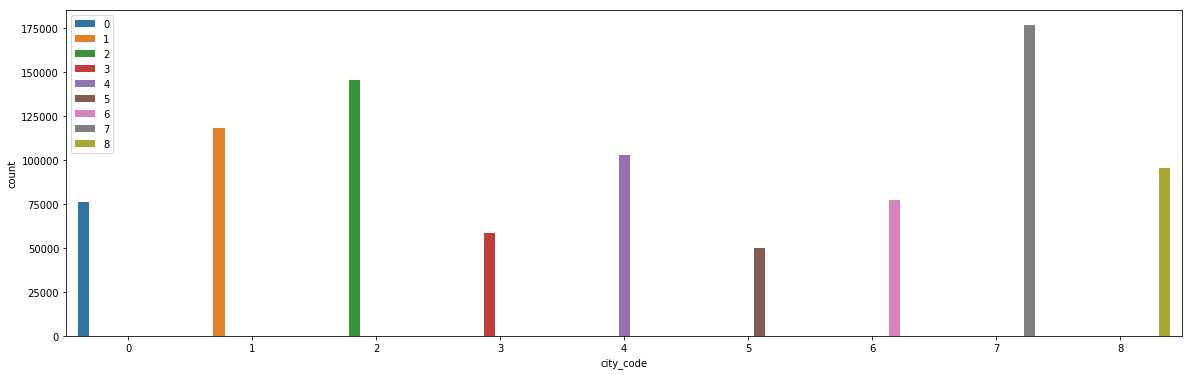

In [153]:
plt.figure(figsize=(20,6))
sns.countplot(df.city_code, hue = df.city_code)
plt.legend(loc='upper left')
plt.show()

### Trip duration

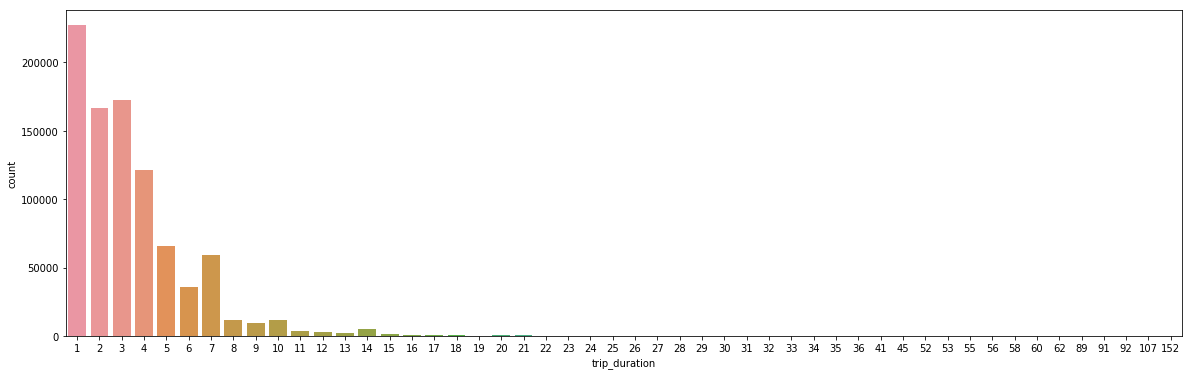

In [154]:
plt.figure(figsize=(20,6))
sns.countplot(df.trip_duration)
plt.show()

### Booking lag

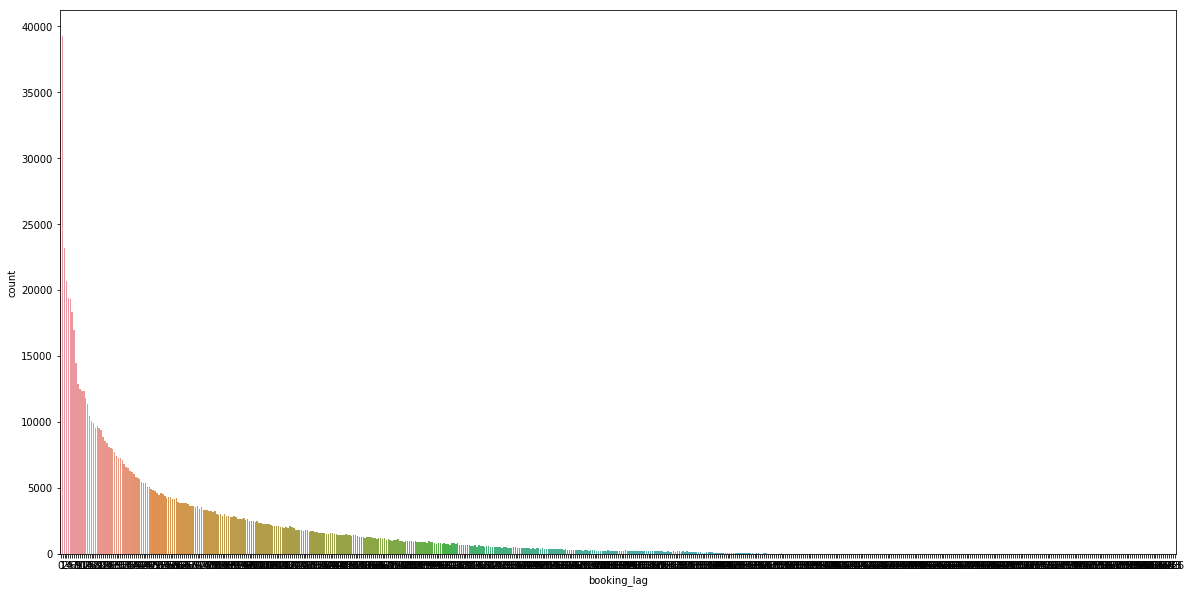

In [155]:
plt.figure(figsize=(20,10))
sns.countplot(df[df.booking_lag >= 0].booking_lag)
plt.show()

## Time-plot

### Single

In [156]:
def plot_single_ts(df, city_code = 0, agg_func = "median",value = "price_per_night", index = "creation_date"):
    # prepare data
    df1 = df.copy()
    df1 = df[df.city_code == city_code]
    df1 = df1.groupby(index, as_index=True).agg({"price_per_night": agg_func})
    #df1 = df1[['price_per_night']]
    
    # -------- PLOTLY -------- #
    # data
    data = [go.Scatter(x=df1.index, y=df1.price_per_night)]
    
    # layout
    layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    ))
    
    # plot
    return plotly.offline.plot({"data": data, "layout": layout}, auto_open=True)

In [157]:
plot_single_ts(df,0, "median")

'file:///Users/tommasocondulmari/Google Drive/DATATHON/temp-plot.html'

### Multiple

In [158]:
def plot_multi_ts(df, value = "price_per_night", agg_func = np.median):
    # prepare data
    df_pivot = df.copy()
    df_pivot = df_pivot.pivot_table(index = 'creation_date', 
                            columns ='city_code', 
                            values = value, 
                            aggfunc = agg_func)
    
    # -------- PLOTLY -------- #
    # data
    city_0 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,0], name = "0")
    city_1 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,1], name = "1")
    city_2 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,2], name = "2")
    city_3 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,3], name = "3")
    city_4 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,4], name = "4")
    city_5 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,5], name = "5")
    city_6 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,6], name = "6")
    city_7 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,7], name = "7")
    city_8 = go.Scatter(x=df_pivot.index, y=df_pivot.iloc[:,8], name = "8")

    data = [city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8]
    
    # layout
    layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    ))
    
    # return plot
    return plotly.offline.plot({"data": data, "layout": layout}, auto_open=True)

In [159]:
plot_multi_ts(df[df.anomaly == 0], "price_per_night", np.mean)

'file:///Users/tommasocondulmari/Google Drive/DATATHON/temp-plot.html'

# 6. Model

In [211]:
# set contamination rate to be used for all models
outliers_fraction = 0.02

In [210]:
df = df.drop(columns=['anomaly_gaussian_city', 'anomaly_gaussian_star_rating'])

## 6.1 Gaussian Envelope - by City

In [212]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

In [213]:
##### creation of 9 differents data set based on city code
df_class0 = df_mod.loc[df_mod['city_code'] == 0, 'price_per_night']
df_class1 = df_mod.loc[df_mod['city_code'] == 1, 'price_per_night']
df_class2 = df_mod.loc[df_mod['city_code'] == 2, 'price_per_night']
df_class3 = df_mod.loc[df_mod['city_code'] == 3, 'price_per_night']
df_class4 = df_mod.loc[df_mod['city_code'] == 4, 'price_per_night']
df_class5 = df_mod.loc[df_mod['city_code'] == 5, 'price_per_night']
df_class6 = df_mod.loc[df_mod['city_code'] == 6, 'price_per_night']
df_class7 = df_mod.loc[df_mod['city_code'] == 7, 'price_per_night']
df_class8 = df_mod.loc[df_mod['city_code'] == 8, 'price_per_night']

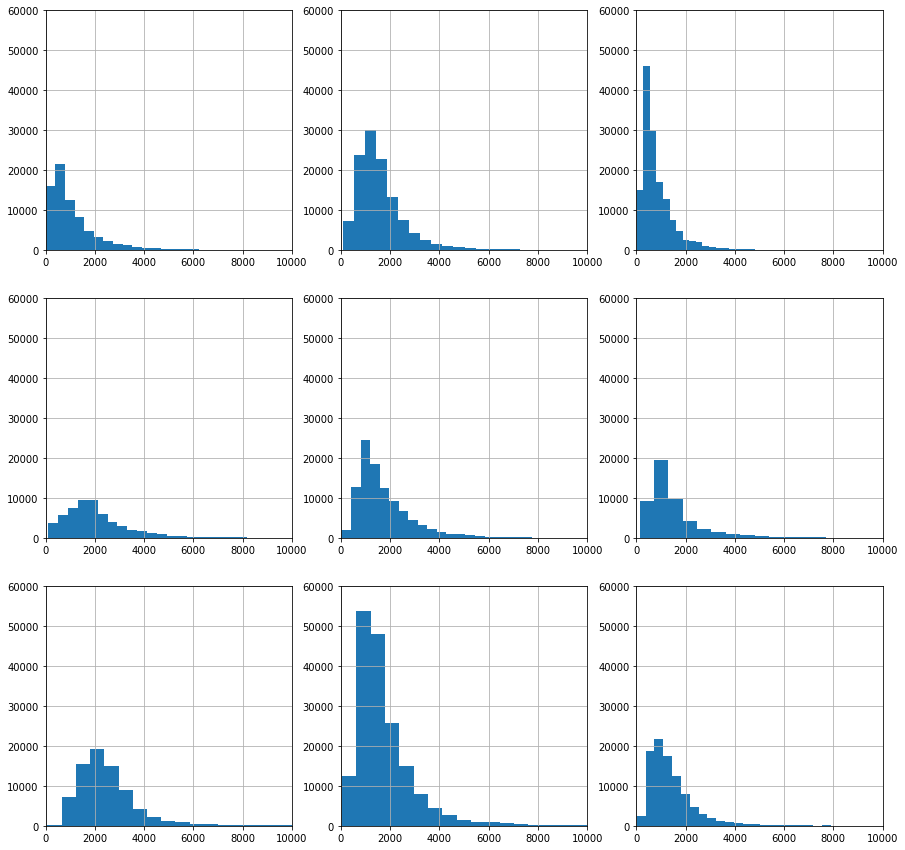

In [214]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(3,3,figsize=(15,15))
for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim([0,10000])
    subplot.set_ylim([0,60000])
    
df_class0.hist(ax=axs[0,0],bins=100)
df_class1.hist(ax=axs[0,1],bins=100)
df_class2.hist(ax=axs[0,2],bins=100)
df_class3.hist(ax=axs[1,0],bins=100)
df_class4.hist(ax=axs[1,1],bins=100)
df_class5.hist(ax=axs[1,2],bins=100)
df_class6.hist(ax=axs[2,0],bins=100)
df_class7.hist(ax=axs[2,1],bins=100)
df_class8.hist(ax=axs[2,2],bins=100)

In [215]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class4.values.reshape(-1,1)
envelope.fit(X_train)
df_class4 = pd.DataFrame(df_class4)
df_class4['deviation'] = envelope.decision_function(X_train)
df_class4['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class5.values.reshape(-1,1)
envelope.fit(X_train)
df_class5 = pd.DataFrame(df_class5)
df_class5['deviation'] = envelope.decision_function(X_train)
df_class5['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class6.values.reshape(-1,1)
envelope.fit(X_train)
df_class6 = pd.DataFrame(df_class6)
df_class6['deviation'] = envelope.decision_function(X_train)
df_class6['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class7.values.reshape(-1,1)
envelope.fit(X_train)
df_class7 = pd.DataFrame(df_class7)
df_class7['deviation'] = envelope.decision_function(X_train)
df_class7['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class8.values.reshape(-1,1)
envelope.fit(X_train)
df_class8 = pd.DataFrame(df_class8)
df_class8['deviation'] = envelope.decision_function(X_train)
df_class8['anomaly'] = envelope.predict(X_train)

In [216]:
# plot the price_per_night repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_per_night']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_per_night']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'price_per_night']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'price_per_night']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'price_per_night']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'price_per_night']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'price_per_night']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'price_per_night']

a4 = df_class4.loc[df_class4['anomaly'] == 1, 'price_per_night']
b4 = df_class4.loc[df_class4['anomaly'] == -1, 'price_per_night']

a5 = df_class5.loc[df_class5['anomaly'] == 1, 'price_per_night']
b5 = df_class5.loc[df_class5['anomaly'] == -1, 'price_per_night']

a6 = df_class6.loc[df_class6['anomaly'] == 1, 'price_per_night']
b6 = df_class6.loc[df_class6['anomaly'] == -1, 'price_per_night']

a7 = df_class7.loc[df_class7['anomaly'] == 1, 'price_per_night']
b7 = df_class7.loc[df_class7['anomaly'] == -1, 'price_per_night']

a8 = df_class8.loc[df_class8['anomaly'] == 1, 'price_per_night']
b8 = df_class8.loc[df_class8['anomaly'] == -1, 'price_per_night']

/Users/tommasocondulmari/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



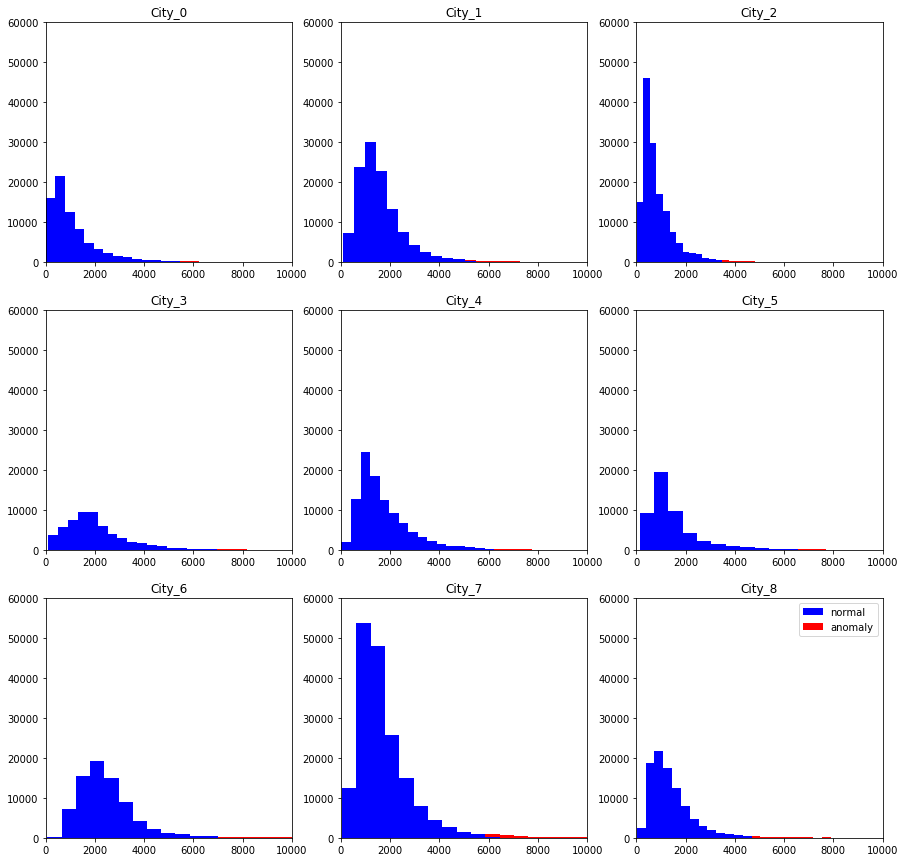

In [217]:
fig, axs = plt.subplots(3,3,figsize=(15,15))
for (m,n), subplot in np.ndenumerate(axs):
    subplot.set_xlim([0,10000])
    subplot.set_ylim([0,60000])
    
axs[0,0].hist([a0,b0], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,2].hist([a2,b2], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a3,b3], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a4,b4], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,2].hist([a5,b5], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,0].hist([a6,b6], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,1].hist([a7,b7], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,2].hist([a8,b8], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

axs[0,0].set_title("City_0")
axs[0,1].set_title("City_1")
axs[0,2].set_title("City_2")
axs[1,0].set_title("City_3")
axs[1,1].set_title("City_4")
axs[1,2].set_title("City_5")
axs[2,0].set_title("City_6")
axs[2,1].set_title("City_7")
axs[2,2].set_title("City_8")
plt.legend()
plt.show()

In [218]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3, df_class4, df_class5, df_class6, df_class7, df_class8])
df_mod['anomaly_gaussian_city'] = df_class['anomaly']
df_mod['anomaly_gaussian_city'] = np.array(df_mod['anomaly_gaussian_city'] == -1).astype(int)

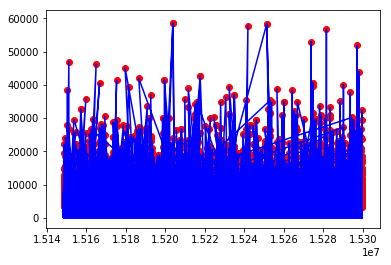

In [219]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_mod.loc[df_mod['anomaly_gaussian_city'] == 1, ('time_epoch', 'price_per_night')] #anomaly

ax.plot(df_mod['time_epoch'], df_mod['price_per_night'], color='blue')
ax.scatter(a['time_epoch'],a['price_per_night'], color='red')
plt.show()

/Users/tommasocondulmari/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



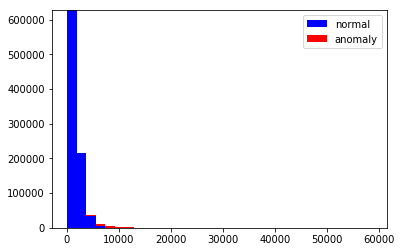

In [220]:
# visualisation of anomaly with price_per_night repartition (viz 2)
a = df_mod.loc[df_mod['anomaly_gaussian_city'] == 0, 'price_per_night']
b = df_mod.loc[df_mod['anomaly_gaussian_city'] == 1, 'price_per_night']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [221]:
# anomalies= df_mod[df_mod['anomaly_gaussian_city']==1]
# anomalies[anomalies['star_rating']=='1']

#### Model Summary

In [222]:
# show number of anomalies
df_mod['anomaly_gaussian_city'].value_counts()

0    881335
1     17988
Name: anomaly_gaussian_city, dtype: int64

In [223]:
# insert prediction to original data frame
# merge data frames
df = df.merge(df_mod[['row_id', 'anomaly_gaussian_city']], on='row_id', how ='left')

In [224]:
# assign 1 to null values which are the one which we exlcluded in df_mod
df.loc[df.anomaly_gaussian_city.isnull(), "anomaly_gaussian_city"] = 1

# transform to integer
df['anomaly_gaussian_city'] = df.anomaly_gaussian_city.astype(int)

## 6.1 Gaussian Envelope - by Star Rating

In [225]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

(0, 4000)

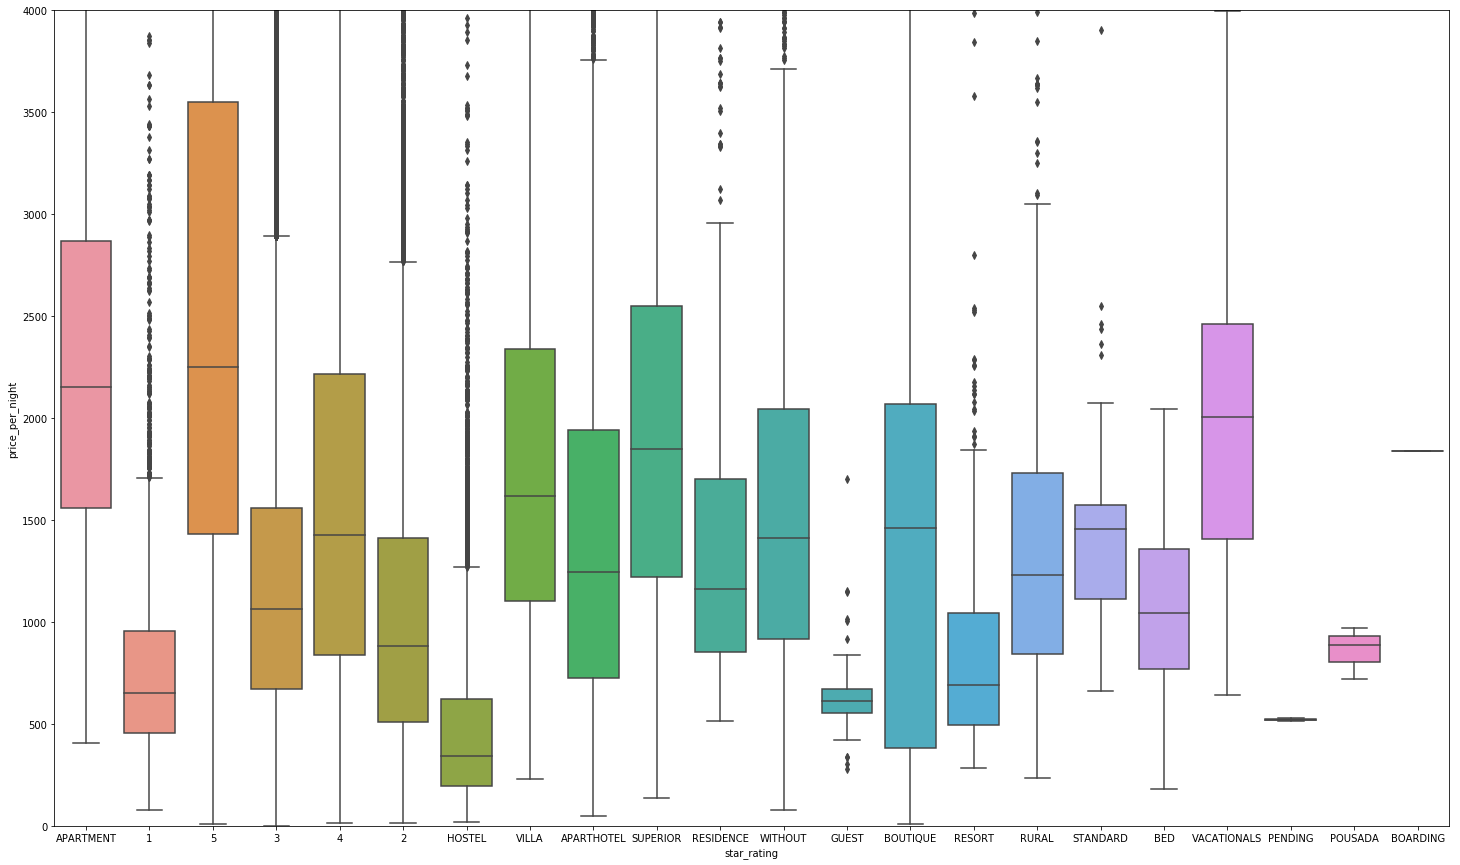

In [226]:
#df2['star_rating_grouped']= df2['star_rating']

df['star_rating_grouped'] = df['star_rating'].map({'RESIDENCE': 'RAR', 'APARTHOTEL': 'RAR',
                    'RURAL': 'RAR', 'APARTMENT': 'AV', 'VACATIONALS': 'AV',
                    'SUPERIOR': 'SV', 'VILLA': 'SV', 'GUEST': 'OTHER',
                    'POUSADA': 'OTHER', 'BED':'OTHER','BOARDING':'OTHER','PENDING':'OTHER',
                    'WITHOUT':'OTHER', '4':'4', '1':'1','2':'2','3':'3', '5':'5', 'SUPERIOR':'SUPERIOR',
                    'BOUTIQUE':'BOUTIQUE', 'HOSTEL':'HOSTEL', 'RESORT':'RESORT', 'STANDARD':'STANDARD'})

plt.subplots(figsize=(25,15))
sns.boxplot(x='star_rating', y='price_per_night', data= df).set_ylim(0,4000)

In [227]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

In [228]:
df_mod.star_rating_grouped.unique()

array(['AV', '1', '5', '3', '4', '2', 'HOSTEL', 'SV', 'RAR', 'SUPERIOR',
       'OTHER', 'BOUTIQUE', 'RESORT', 'STANDARD'], dtype=object)

In [229]:
##### creation of 9 differents data set based on city code
df_class0 = df_mod.loc[df_mod['star_rating_grouped'] == "1", 'price_per_night']
df_class1 = df_mod.loc[df_mod['star_rating_grouped'] == "2", 'price_per_night']
df_class2 = df_mod.loc[df_mod['star_rating_grouped'] == "3", 'price_per_night']
df_class3 = df_mod.loc[df_mod['star_rating_grouped'] == "4", 'price_per_night']
df_class4 = df_mod.loc[df_mod['star_rating_grouped'] == "5", 'price_per_night']
df_class5 = df_mod.loc[df_mod['star_rating_grouped'] == "AV", 'price_per_night']
df_class6 = df_mod.loc[df_mod['star_rating_grouped'] == "BOUTIQUE", 'price_per_night']
df_class7 = df_mod.loc[df_mod['star_rating_grouped'] == "HOSTEL", 'price_per_night']
df_class8 = df_mod.loc[df_mod['star_rating_grouped'] == "OTHER", 'price_per_night']
df_class9 = df_mod.loc[df_mod['star_rating_grouped'] == "RAR", 'price_per_night']
df_class10 = df_mod.loc[df_mod['star_rating_grouped'] == "RESORT", 'price_per_night']
df_class11 = df_mod.loc[df_mod['star_rating_grouped'] == "STANDARD", 'price_per_night']
df_class12 = df_mod.loc[df_mod['star_rating_grouped'] == "SUPERIOR", 'price_per_night']
df_class13 = df_mod.loc[df_mod['star_rating_grouped'] == "SV", 'price_per_night']

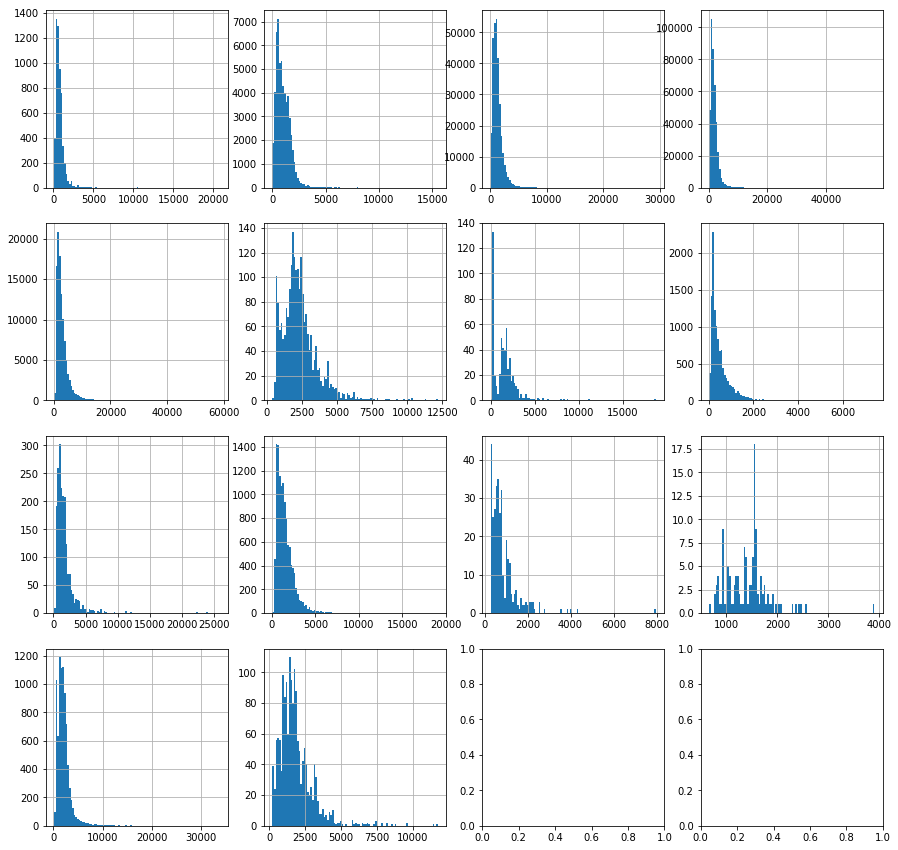

In [230]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(4,4,figsize=(15,15))
# for (m,n), subplot in np.ndenumerate(axs):
#     subplot.set_xlim([0,10000])
#     subplot.set_ylim([0,60000])
    
df_class0.hist(ax=axs[0,0],bins=100)
df_class1.hist(ax=axs[0,1],bins=100)
df_class2.hist(ax=axs[0,2],bins=100)
df_class3.hist(ax=axs[0,3],bins=100)
df_class4.hist(ax=axs[1,0],bins=100)
df_class5.hist(ax=axs[1,1],bins=100)
df_class6.hist(ax=axs[1,2],bins=100)
df_class7.hist(ax=axs[1,3],bins=100)
df_class8.hist(ax=axs[2,0],bins=100)
df_class9.hist(ax=axs[2,1],bins=100)
df_class10.hist(ax=axs[2,2],bins=100)
df_class11.hist(ax=axs[2,3],bins=100)
df_class12.hist(ax=axs[3,0],bins=100)
df_class13.hist(ax=axs[3,1],bins=100)

In [231]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class4.values.reshape(-1,1)
envelope.fit(X_train)
df_class4 = pd.DataFrame(df_class4)
df_class4['deviation'] = envelope.decision_function(X_train)
df_class4['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class5.values.reshape(-1,1)
envelope.fit(X_train)
df_class5 = pd.DataFrame(df_class5)
df_class5['deviation'] = envelope.decision_function(X_train)
df_class5['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class6.values.reshape(-1,1)
envelope.fit(X_train)
df_class6 = pd.DataFrame(df_class6)
df_class6['deviation'] = envelope.decision_function(X_train)
df_class6['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class7.values.reshape(-1,1)
envelope.fit(X_train)
df_class7 = pd.DataFrame(df_class7)
df_class7['deviation'] = envelope.decision_function(X_train)
df_class7['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class8.values.reshape(-1,1)
envelope.fit(X_train)
df_class8 = pd.DataFrame(df_class8)
df_class8['deviation'] = envelope.decision_function(X_train)
df_class8['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class9.values.reshape(-1,1)
envelope.fit(X_train)
df_class9 = pd.DataFrame(df_class9)
df_class9['deviation'] = envelope.decision_function(X_train)
df_class9['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class10.values.reshape(-1,1)
envelope.fit(X_train)
df_class10 = pd.DataFrame(df_class10)
df_class10['deviation'] = envelope.decision_function(X_train)
df_class10['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class11.values.reshape(-1,1)
envelope.fit(X_train)
df_class11 = pd.DataFrame(df_class11)
df_class11['deviation'] = envelope.decision_function(X_train)
df_class11['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class12.values.reshape(-1,1)
envelope.fit(X_train)
df_class12 = pd.DataFrame(df_class12)
df_class12['deviation'] = envelope.decision_function(X_train)
df_class12['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class13.values.reshape(-1,1)
envelope.fit(X_train)
df_class13 = pd.DataFrame(df_class13)
df_class13['deviation'] = envelope.decision_function(X_train)
df_class13['anomaly'] = envelope.predict(X_train)

In [232]:
# plot the price_per_night repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_per_night']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_per_night']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'price_per_night']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'price_per_night']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'price_per_night']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'price_per_night']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'price_per_night']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'price_per_night']

a4 = df_class4.loc[df_class4['anomaly'] == 1, 'price_per_night']
b4 = df_class4.loc[df_class4['anomaly'] == -1, 'price_per_night']

a5 = df_class5.loc[df_class5['anomaly'] == 1, 'price_per_night']
b5 = df_class5.loc[df_class5['anomaly'] == -1, 'price_per_night']

a6 = df_class6.loc[df_class6['anomaly'] == 1, 'price_per_night']
b6 = df_class6.loc[df_class6['anomaly'] == -1, 'price_per_night']

a7 = df_class7.loc[df_class7['anomaly'] == 1, 'price_per_night']
b7 = df_class7.loc[df_class7['anomaly'] == -1, 'price_per_night']

a8 = df_class8.loc[df_class8['anomaly'] == 1, 'price_per_night']
b8 = df_class8.loc[df_class8['anomaly'] == -1, 'price_per_night']

a9 = df_class9.loc[df_class9['anomaly'] == 1, 'price_per_night']
b9 = df_class9.loc[df_class9['anomaly'] == -1, 'price_per_night']

a10 = df_class10.loc[df_class10['anomaly'] == 1, 'price_per_night']
b10 = df_class10.loc[df_class10['anomaly'] == -1, 'price_per_night']

a11 = df_class11.loc[df_class11['anomaly'] == 1, 'price_per_night']
b11 = df_class11.loc[df_class11['anomaly'] == -1, 'price_per_night']

a12 = df_class12.loc[df_class12['anomaly'] == 1, 'price_per_night']
b12 = df_class12.loc[df_class12['anomaly'] == -1, 'price_per_night']

a13 = df_class13.loc[df_class13['anomaly'] == 1, 'price_per_night']
b13 = df_class13.loc[df_class13['anomaly'] == -1, 'price_per_night']

/Users/tommasocondulmari/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

No handles with labels found to put in legend.


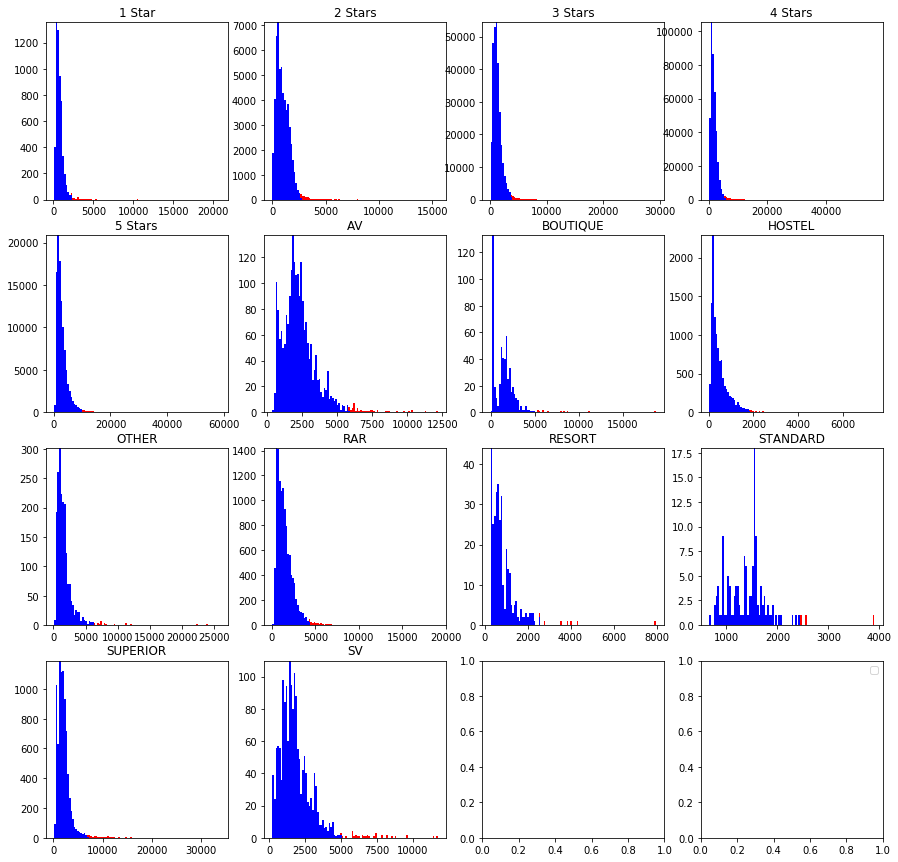

In [233]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
# for (m,n), subplot in np.ndenumerate(axs):
#     subplot.set_xlim([0,10000])
#     subplot.set_ylim([0,60000])
    
axs[0,0].hist([a0,b0], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,2].hist([a2,b2], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,3].hist([a3,b3], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a4,b4], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a5,b5], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,2].hist([a6,b6], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,3].hist([a7,b7], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,0].hist([a8,b8], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,1].hist([a9,b9], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,2].hist([a10,b10], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2,3].hist([a11,b11], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,0].hist([a12,b12], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[3,1].hist([a13,b13], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

axs[0,0].set_title("1 Star")
axs[0,1].set_title("2 Stars")
axs[0,2].set_title("3 Stars")
axs[0,3].set_title("4 Stars")
axs[1,0].set_title("5 Stars")
axs[1,1].set_title("AV")
axs[1,2].set_title("BOUTIQUE")
axs[1,3].set_title("HOSTEL")
axs[2,0].set_title("OTHER")
axs[2,1].set_title("RAR")
axs[2,2].set_title("RESORT")
axs[2,3].set_title("STANDARD")
axs[3,0].set_title("SUPERIOR")
axs[3,1].set_title("SV")

plt.legend()
plt.show()

In [234]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3, df_class4, df_class5, df_class6, df_class7, df_class8,
                     df_class9, df_class10, df_class11, df_class12, df_class13])
df_mod['anomaly_gaussian_star_rating'] = df_class['anomaly']
df_mod['anomaly_gaussian_star_rating'] = np.array(df_mod['anomaly_gaussian_star_rating'] == -1).astype(int)

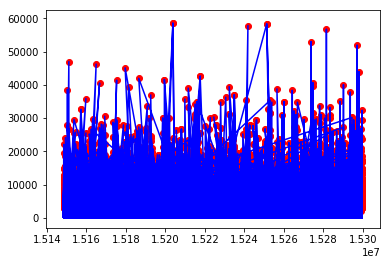

In [235]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_mod.loc[df_mod['anomaly_gaussian_star_rating'] == 1, ('time_epoch', 'price_per_night')] #anomaly

ax.plot(df_mod['time_epoch'], df_mod['price_per_night'], color='blue')
ax.scatter(a['time_epoch'],a['price_per_night'], color='red')
plt.show()

/Users/tommasocondulmari/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



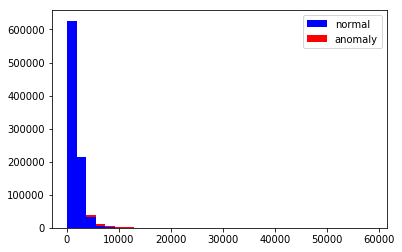

In [236]:
# visualisation of anomaly with price_per_night repartition (viz 2)
a = df_mod.loc[df_mod['anomaly_gaussian_star_rating'] == 0, 'price_per_night']
b = df_mod.loc[df_mod['anomaly_gaussian_star_rating'] == 1, 'price_per_night']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [237]:
# anomalies= df_mod[df_mod['anomaly_gaussian_star_rating']==1]
# anomalies[anomalies['star_rating']=='1']

#### Model Summary

In [238]:
# show number of anomalies
df_mod['anomaly_gaussian_star_rating'].value_counts()

0    881335
1     17988
Name: anomaly_gaussian_star_rating, dtype: int64

In [239]:
# insert prediction to original data frame
# merge data frames
df = df.merge(df_mod[['row_id', 'anomaly_gaussian_star_rating']], on='row_id', how ='left')

In [240]:
# assign 1 to null values which are the one which we exlcluded in df_mod
df.loc[df.anomaly_gaussian_star_rating.isnull(), "anomaly_gaussian_star_rating"] = 1

# transform to integer
df['anomaly_gaussian_star_rating'] = df.anomaly_gaussian_star_rating.astype(int)

# 7. Submission

In [241]:
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,...,booking_lag,price_per_night,creation_date_wday,creation_date_wday_name,weekend_trip,time_epoch,anomaly,star_rating_grouped,anomaly_gaussian_city,anomaly_gaussian_star_rating
0,-8311839113995541010,3308171939935307043,-6758561262332566539,1,BL-6,OPQ,APT,RO,2018-05-22,2018-06-30,...,39,2838.499200,1,Tuesday,1,15269472,0,AV,0,0
1,-7782336419181110673,-3269338087318960614,-9183082468560560492,8,ST,NOR,DBT,BB,2018-05-22,2018-07-20,...,59,889.617300,1,Tuesday,1,15269472,0,1,0,0
2,-8185637807857201025,-7171383991101553094,-573449065418159891,6,XX-KG-SU,NOR,DBL,RO,2018-05-22,2018-05-24,...,2,3463.942871,1,Tuesday,1,15269472,0,5,0,0
3,4398388086357359587,3421074771505167982,215759992217563846,2,ST,NONE,TWN,BB,2018-05-22,2018-06-08,...,17,1107.261668,1,Tuesday,1,15269472,0,3,0,0
4,-7098207282290159573,7965439627984399332,1006074091123194605,7,ST,NOR,DBT,RO,2018-05-22,2018-06-11,...,20,862.100000,1,Tuesday,0,15269472,0,3,0,0


In [242]:
df_sub = df[['row_id', 'anomaly_gaussian_city', 'anomaly_gaussian_star_rating']]

In [243]:
df_sub['final_prediction'] = df_sub['anomaly_gaussian_city'] * df_sub['anomaly_gaussian_star_rating']

/Users/tommasocondulmari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [244]:
# show number of anomalies
df_sub['final_prediction'].value_counts()

0    889928
1      9549
Name: final_prediction, dtype: int64

In [247]:
df_sub[['row_id','final_prediction']].to_csv('./data/prediction.csv', index = False)

# 8. Alternative Approaches

## 8.1 Local Outlier Factor

In [91]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

In [92]:
df_mod = df_mod[['city_code','star_rating','price_per_night', 'row_id']]
df_mod = pd.get_dummies(df_mod)

lof_model = LocalOutlierFactor(n_neighbors = 35, contamination = outliers_fraction, n_jobs = -1)
lof_model.fit(df_mod.loc[:, df.columns != 'row_id'])
y_pred = lof_model.fit_predict(df_mod)
df_mod['anomaly_lof'] = y_pred
df_mod['anomaly_lof'] = df_mod['anomaly_lof'].map( {1: 0, -1: 1} )

KeyboardInterrupt: 

#### Model Summary

In [88]:
# show number of anomalies
df_mod['anomaly_lof'].value_counts()

anomaly_gaussian_star_rating
0    897312
1      2011
Name: id_hkey, dtype: int64

In [67]:
# insert prediction to original data frame
# merge data frames
df = df.merge(df_mod[['row_id', 'anomaly_lof']], on='row_id', how ='left')

AttributeError: 'DataFrame' object has no attribute 'anomaly_gaussian'

In [89]:
# assign 1 to null values which are the one which we exlcluded in df_mod
df.loc[df.anomaly_lof.isnull(), "anomaly_lof"] = 1

# transform to integer
df['anomaly_lof'] = df.anomaly_lof.astype(int)

## 8.2 Isolation Forest

In [ ]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

In [ ]:
df_mod = df.loc[['city_code','star_rating','price_per_night', 'row_id']]
df_mod = pd.get_dummies(df_mod)
df_mod.head()

if_model = IsolationForest(max_samples = 100, verbose = 1, contamination = outliers_fraction)
if_model.fit(df_mod.loc[:, df.columns != 'row_id'])
y_pred = lof_model.fit_predict(df_mod)
df_mod['anomaly_if'] = y_pred
df_mod['anomaly_if'] = df_mod['anomaly_if'].map( {1: 0, -1: 1} )

df_mod['anomaly_if'].value_counts()

#### Model Summary

In [88]:
# show number of anomalies
df_mod['anomaly_if'].value_counts()

anomaly_gaussian_star_rating
0    897312
1      2011
Name: id_hkey, dtype: int64

In [67]:
# insert prediction to original data frame
# merge data frames
df = df.merge(df_mod[['row_id', 'anomaly_if']], on='row_id', how ='left')

AttributeError: 'DataFrame' object has no attribute 'anomaly_gaussian'

In [89]:
# assign 1 to null values which are the one which we exlcluded in df_mod
df.loc[df.anomaly_if.isnull(), "anomaly_if"] = 1

# transform to integer
df['anomaly_if'] = df.anomaly_if.astype(int)

## 8.3 Clustering

In [ ]:
df_mod = df.copy()
df_mod = df_mod[df_mod['anomaly'] == 0]

In [ ]:
# City Code to Category
df['city_code'] = df['city_code'].map({0: 'city_0', 1: 'city_1',
                    2: 'city_2', 3: 'city_3', 4: 'city_4',
                    5: 'city_5', 6: 'city_6', 7: 'city_7',
                    8: 'city_8'})

In [ ]:
df_mod = df[df['anomaly'] == 0]

In [ ]:
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.00223

In [ ]:
df_mod.head()

In [ ]:
#Encode Useful Data
df_mod = df_mod.drop(columns = ['hotel_hkey', 'id_hkey', 'contract_id_hkey', 'category_room', 'contract_type','arrival_date','creation_date','departure_date'])

#Hot Encode Useful Columns
#get dummies

df_mod= pd.get_dummies(df_mod)

In [ ]:
#test sample
#df= df.sample(n=100000) 
columns= df_mod.columns.values
columns

In [ ]:
data = df_mod[['total_cost', 'trip_duration', 'booking_lag',
       'price_per_night', 'weekend_trip',
       'time_epoch', 'city_code_city_0', 'city_code_city_1',
       'city_code_city_2', 'city_code_city_3', 'city_code_city_4',
       'city_code_city_5', 'city_code_city_6', 'city_code_city_7',
       'city_code_city_8', 'room_type_APT', 'room_type_BED',
       'star_rating_1',
       'star_rating_2', 'star_rating_3', 'star_rating_4', 'star_rating_5',
       'star_rating_APARTHOTEL', 'star_rating_APARTMENT',
       'star_rating_BED', 'star_rating_BOARDING', 'star_rating_BOUTIQUE',
       'star_rating_GUEST', 'star_rating_HOSTEL', 'star_rating_PENDING',
       'star_rating_POUSADA', 'star_rating_RESIDENCE',
       'star_rating_RESORT', 'star_rating_RURAL', 'star_rating_STANDARD',
       'star_rating_SUPERIOR', 'star_rating_VACATIONALS',
       'star_rating_VILLA', 'star_rating_WITHOUT', 'creation_date_day_name_Friday', 'creation_date_day_name_Monday',
       'creation_date_day_name_Saturday', 'creation_date_day_name_Sunday',
       'creation_date_day_name_Thursday',
       'creation_date_day_name_Tuesday',
       'creation_date_day_name_Wednesday']]

In [ ]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
#standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [ ]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(18, 30)
kmeans = [KMeans(n_clusters=i, n_jobs = -1).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
# Not clear for me, I choose 10 centroids arbitrarily and add these data to the central dataframe
df_mod['cluster'] = kmeans[30].predict(data)

#Extracting principal_feature vector to attach to dataframe

principal_feature1 = pd.DataFrame(data[0])
principal_feature2 = pd.DataFrame(data[1])

#match index for sample
new_row_id = df_mod.row_id.reset_index()
new_row_id = new_row_id.drop(columns = ['index'])

principal_feature1['index'] = new_row_id

principal_feature2['index'] = new_row_id

#merge principal_feature1
df_mod = df_mod.merge(principal_feature1, left_on='row_id', right_on='index', how ='outer')
df_mod = df_mod.rename(columns={0:'principal_feature1'})
###drop index
df_mod = df_mod.drop(columns=['index'])

#merge principal_feature2
df_mod = df_mod.merge(principal_feature2, left_on='row_id', right_on='index', how ='outer')
df_mod = df_mod.rename(columns={1:'principal_feature2'})

#drop index
df_mod = df_mod.drop(columns=['index'])

#Count observations per cluster
df_mod['cluster'].value_counts()

In [ ]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
#colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey', 15: 'magenta'}
#colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown'}
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white'}
ax.scatter(df_mod['principal_feature1'], df_mod['principal_feature2'], c=df_mod["cluster"].apply(lambda x: colors[x]))
#ax.scatter(df1['price_per_night'], df1['booking_lag'], c=df1["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
#colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey', 15: 'magenta'}
#colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown',9:'purple'}
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white'}
ax.scatter(df_mod['booking_lag'], df_mod['price_per_night'], c=df_mod["cluster"].apply(lambda x: colors[x]))
#ax.scatter(df1['price_per_night'], df1['booking_lag'], c=df1["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])

number_of_outliers = int(outliers_fraction*len(distance))

threshold = distance.nlargest(number_of_outliers).min()

# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
#df['anomaly21']= (distance >= threshold).astype(int)
anomaly_cluster = pd.DataFrame((distance >= threshold).astype(int))


In [ ]:
#attach the target to the df

#match index for sample
new_row_id = df_mod.row_id.reset_index()
new_row_id = new_row_id.drop(columns = ['index'])

anomaly_cluster['index'] = new_row_id

#merge anomaly21
df_mod = df_mod.merge(anomaly_cluster, left_on='row_id', right_on='index', how ='outer')

df_mod = df_mod.rename(columns={0:'anomaly_cluster'})

#drop customer id
df_mod = df_mod.drop(columns=['index'])

In [ ]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_mod['principal_feature1'], df_mod['principal_feature2'], c=df_mod["anomaly21"].apply(lambda x: colors[x]))
#ax.scatter(df['price_per_night'], df['booking_lag'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df_mod.loc[df_mod['anomaly_cluster'] == 0, 'price_per_night']
b = df_mod.loc[df_mod['anomaly_cluster'] == 1, 'price_per_night']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

df_mod[df_mod['anomaly_cluster'] == 1]['row_id'].count()